# What areas of SF party hardest? 

**Questions**
1. Which neighborhoods received the most complaints?
2. When (times of day and months of the year) are most complaints filed?
3. Are there some locations that receive significantly more complaints that others?

In [1]:
import pandas as pd
import geopandas as gdp
import gpdvega
import descartes

pd.options.display.max_rows = None

%matplotlib inline

import altair as alt
from vega_datasets import data

In [2]:
import os

data_dir = os.environ['DATA_DIR']   # path to data/

### Importing data from local file

In [3]:
noise_comps = pd.read_csv(os.path.join(data_dir, '311_Cases.csv'), parse_dates=['Opened', 'Closed', 'Updated'])

In [4]:
noise_comps.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,11914612,2020-01-08 04:49:02,2020-01-09 06:00:14,2020-01-09 06:00:14,Closed,Accepted - Noise informational reports are clo...,Noise Report Queue,Noise Report,other_excessive_noise,Noise Report - other_excessive_noise,"316 LAWTON ST, SAN FRANCISCO, CA, 94122",LAWTON ST,7.0,Inner Sunset,TARAVAL,37.758553,-122.466286,"(37.75855255, -122.46628571)",Web,NaN
1,9209249,2018-06-30 20:35:38,2018-06-30 21:07:00,2018-06-30 21:07:00,Closed,Comment Noted - Please report to SFPD by calli...,311 Supervisor Queue,Noise Report,Noise Issue,Other,"601 CLAYTON ST, SAN FRANCISCO, CA, 94117",CLAYTON ST,5.0,Haight Ashbury,PARK,37.769657,-122.448758,"(37.76965675, -122.44875848)",Mobile/Open311,NaN
2,9209125,2018-06-30 19:36:58,2018-06-30 19:46:00,2018-06-30 19:46:00,Closed,Comment Noted - Please contact Non Emergency p...,311 Supervisor Queue,Noise Report,Noise Issue,Other,"390 FRANCONIA ST, SAN FRANCISCO, CA, 94110",FRANCONIA ST,9.0,Peralta Heights,INGLESIDE,37.743768,-122.408280,"(37.7437682, -122.4082804)",Web,NaN
3,9209119,2018-06-30 19:33:19,2018-06-30 20:11:00,2018-06-30 20:11:00,Closed,Comment Noted - sent email to customer.,311 Supervisor Queue,Noise Report,Noise Issue,Other,"958 QUINTARA ST, SAN FRANCISCO, CA, 94116",QUINTARA ST,7.0,Golden Gate Heights,TARAVAL,37.748650,-122.475630,"(37.74865, -122.47563)",Mobile/Open311,NaN
4,9209062,2018-06-30 19:05:43,2018-06-30 19:14:00,2018-06-30 19:14:00,Closed,Comment Noted,311 Supervisor Queue,Noise Report,Noise Issue,Other,"24 THOR AVE, SAN FRANCISCO, CA, 94131",THOR AVE,8.0,Glen Park,INGLESIDE,37.735414,-122.434688,"(37.73541403, -122.43468795)",Mobile/Open311,NaN


## 1. WHICH NEIGHBORHOODS RECEIVED THE MOST COMPLAINTS?

### Counting and Sorting Data

In [5]:
neighborhoods = noise_comps.groupby(by="Neighborhood").CaseID.count().reset_index()

In [6]:
sorted_neighborhoods = neighborhoods.sort_values(by=['CaseID','Neighborhood'], ascending=False)
sorted_neighborhoods.columns = ['Neighborhood', 'Complaints']

In [7]:
top_neighborhoods = sorted_neighborhoods.head(10)
top_neighborhoods

,Neighborhood,Complaints
63,Mission,770
97,South of Market,720
76,Outer Sunset,365
54,Lower Nob Hill,316
105,Tenderloin,310
65,Mission Dolores,254
75,Outer Richmond,182
15,Civic Center,180
77,Pacific Heights,161
36,Haight Ashbury,153


### Plotting Data

In [8]:
color_range = colors = ['grey', 'silver', 'rosybrown', 'firebrick', 'brown', 'maroon', 'darkred']

bars = alt.Chart(top_neighborhoods).mark_bar().encode(
    x=alt.X('Complaints', axis=alt.Axis(title='Noise Complaints')),
    y=alt.Y('Neighborhood', sort='x'),
    color=alt.Color('Complaints', scale=alt.Scale(range=color_range))
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3    # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Complaints:Q'
)

(bars + text).properties(height=300, width=800)

alt.LayerChart(...)

### Mapping Data

In [9]:
noise_comps = noise_comps.rename(columns={'Point' : 'location'})
noise_comps = noise_comps[noise_comps.location != '(0.0, 0.0)']

In [10]:
from shapely.geometry import Point
import re

def point_from_str(location):
    lat, lon = map(float, re.findall(r'(-?\d+\.\d+)', location))
    return (lon, lat)

# Create a coordinates column with proper lon/lat tuples
noise_comps['coordinates'] = noise_comps.location.apply(point_from_str)
# Convert to Geopandas Points
noise_comps['coordinates'] = noise_comps['coordinates'].apply(Point)

In [11]:
comps_gdp = gdp.GeoDataFrame(noise_comps, geometry='coordinates')

In [12]:
shapes = gdp.read_file('zip://Analysis Neighborhoods.zip')

alt.Chart(...)

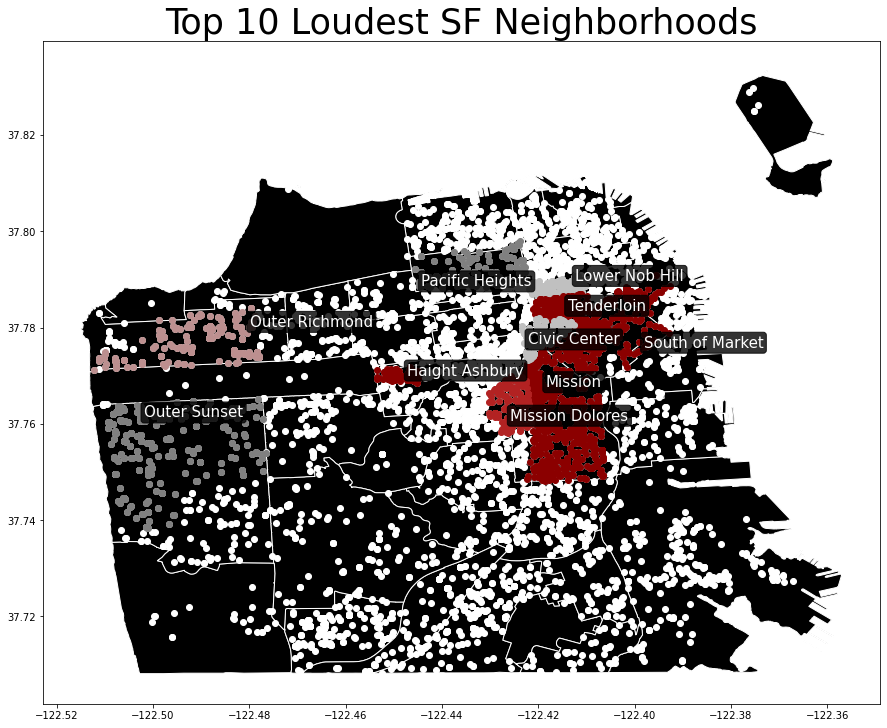

In [25]:
ax = shapes.plot(color='k', edgecolor='white', figsize=(15, 15))
ax.set_facecolor('white')  # sets background to white
ax.set_title('Top 10 Loudest SF Neighborhoods', fontsize=35)   # sets title

comps_gdp.plot(ax=ax, color='white')

bbox_props = dict(boxstyle="round, pad=0.2", fc="black", alpha=0.8)   # text box style

def map_neighborhoods(dataset, colors):
    n = 1
    for neighborhood in dataset.Neighborhood:
        data = comps_gdp[comps_gdp.Neighborhood == neighborhood]
        data.plot(
            ax=ax, color=colors[10%n - 1]).annotate(
            neighborhood, xy=(data.Longitude.iloc[100], 
                              data.Latitude.iloc[100]),   # arbitrary lon,lat values to set labels
            color='white',
            fontsize = 15,
            bbox=bbox_props   # sets round boxes around text
        )
        n += 1   # sets colors by increment

map_neighborhoods(top_neighborhoods, color_range)
bars.properties(height=300, width=800)

## 2. WHEN ARE MOST COMPLAINTS FILED?

### Extracting Months and Hours of the day

In [14]:
import calendar

noise_comps['Month'] = pd.DatetimeIndex(noise_comps['Opened']).month
noise_comps['Month'] = noise_comps['Month'].apply(lambda n: calendar.month_abbr[n])

noise_comps['Hour'] = pd.DatetimeIndex(noise_comps['Opened']).hour

comps_bydate = noise_comps.groupby(by=['Month', 'Hour']).CaseID.count().reset_index()

### Plotting Data

Text(0.5, 1.0, 'Loudest Times and Months in SF')

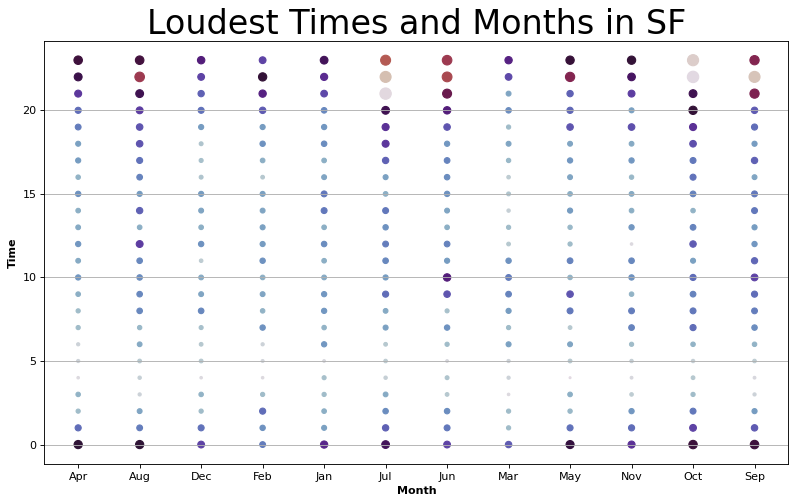

In [15]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

scatter = plt.scatter(comps_bydate.Month, comps_bydate.Hour, s=comps_bydate.CaseID, 
                      c=comps_bydate.CaseID, cmap='twilight')
plt.xlabel("Month", fontweight='bold')
plt.ylabel("Time", fontweight='bold')
plt.grid(axis='y')   # sets grid
plt.title('Loudest Times and Months in SF', fontsize=30)   # sets title

## 3. DO SOME LOCATIONS RECEIVE MORE COMPLAINTS THAT OTHERS?

In [16]:
top_noises = noise_comps.groupby(by=['location', 'Address', 'Latitude', 'Longitude']).CaseID.count().reset_index().sort_values(
    by=['CaseID'], ascending=False).head(10)

# Create a coordinates column with proper lon/lat tuples
top_noises['coordinates'] = top_noises.location.apply(point_from_str)
# Convert to Geopandas Points
top_noises['coordinates'] = top_noises['coordinates'].apply(Point)
top_noises_gdp = gdp.GeoDataFrame(top_noises, geometry='coordinates')

top_noises_gdp.head()

,location,Address,Latitude,Longitude,CaseID,coordinates
2184,"(37.76142883, -122.50183868)","1360 43RD AVE, SAN FRANCISCO, CA, 94122",37.761429,-122.501839,89,POINT (-122.50184 37.76143)
326,"(37.72041321, -122.45933533)","1017 CAPITOL AVE, SAN FRANCISCO, CA, 94112",37.720413,-122.459335,77,POINT (-122.45934 37.72041)
4269,"(37.7797, -122.42)","475 VAN NESS AVE, SAN FRANCISCO, CA, 94102",37.779700,-122.420000,47,POINT (-122.42000 37.77970)
1037,"(37.74295807, -122.42730713)","224 DAY ST, SAN FRANCISCO, CA, 94131",37.742958,-122.427307,27,POINT (-122.42731 37.74296)
291,"(37.7197876, -122.46476746)","212 GARFIELD ST, SAN FRANCISCO, CA, 94132",37.719788,-122.464767,16,POINT (-122.46477 37.71979)


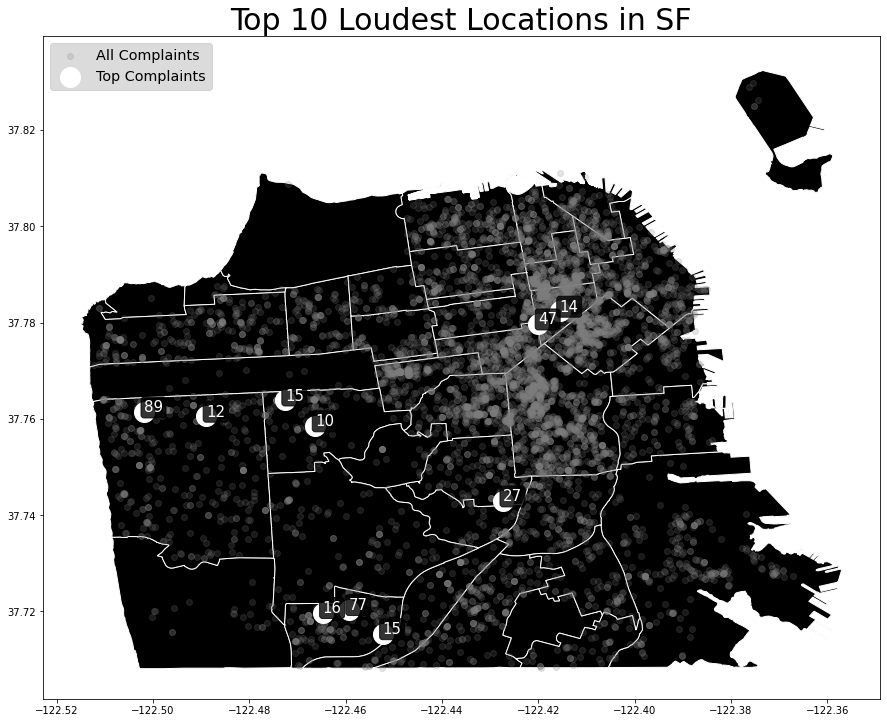

In [17]:
ax = shapes.plot(color='k', edgecolor='white', figsize=(15, 15))
ax.set_facecolor('white')   # sets background to white
ax.set_title('Top 10 Loudest Locations in SF', fontsize=30)   #sets title


comps_gdp.plot(ax=ax, color='grey', alpha=0.2)   # all complaints layer
complaints = top_noises_gdp.plot(ax=ax, color='white', markersize = 400)   # top complaints layer
complaints.legend(('All Complaints', 'Top Complaints', 'Permits'), loc='upper left', 
                           fontsize = 'x-large', facecolor = 'lightgrey')   # legend

def annotate_map(count, longitude, latitude):
    complaints.annotate(
            count, xy=(longitude, 
                              latitude),
            color='white',
            fontsize = 15,
            bbox=bbox_props   # sets round boxes around text
        )

for i, row in top_noises.iterrows():
    annotate_map(row['CaseID'], row['Longitude'], row['Latitude'])

When merged with noise permit data, coordinates don't match. However, some locations appear to nearly overlap with permits granted by the city (see map below).

In [18]:
noise_permits = pd.read_csv(os.path.join(data_dir, 'Night_Noise_Permits.csv'))

def point_from_str_rev(location):
    lat, lon = map(float, re.findall(r'(-?\d+\.\d+)', location))
    return (lat, lon)

# Create a coordinates column with proper lon/lat tuples
noise_permits['coordinates'] = noise_permits.point.apply(point_from_str_rev)
# Convert to Geopandas Points
noise_permits['coordinates'] = noise_permits['coordinates'].apply(Point)
noise_permits_gdp = gdp.GeoDataFrame(noise_permits, geometry='coordinates')

# Data Source: https://data.sfgov.org/Housing-and-Buildings/Night-Noise-Permits/e7pr-36bt/data

In [19]:
merged = pd.merge(top_noises, noise_permits, on="coordinates")
merged

,location,Address,Latitude,Longitude,CaseID,coordinates,start_date,end_date,start_end_time_each_day,nnp,...,address,off_hours_contact_name,off_hours_contact_phone,type_of_work,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods


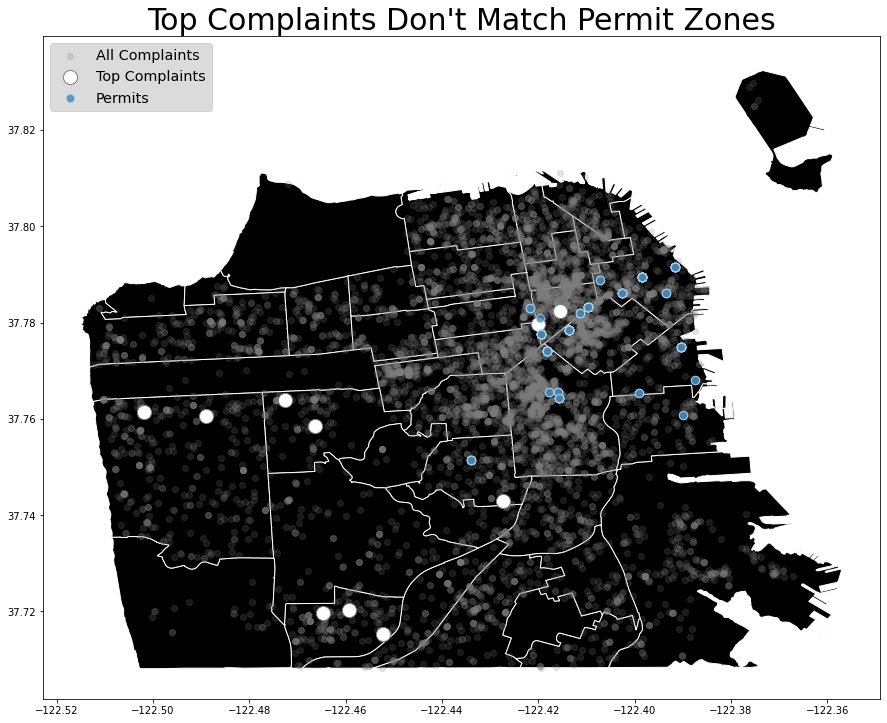

In [20]:
ax = shapes.plot(color='k', edgecolor='white', figsize=(15, 15))
ax.set_facecolor('white')   # sets background to white
plt.title("Top Complaints Don't Match Permit Zones", fontsize=30)   # sets title

base = comps_gdp.plot(ax=ax, color='grey', alpha=0.2)   # all complaints layer
complaints = top_noises_gdp.plot(ax=ax, color='white', edgecolor = 'grey', markersize = 200)   # top complaints layer
permits = noise_permits_gdp.plot(ax=ax, color='steelblue', edgecolor = 'lightblue', 
                                 markersize = 70, alpha = 0.8)   # permits layer
complaints.legend(('All Complaints', 'Top Complaints', 'Permits'), loc='upper left', 
                           fontsize = 'x-large', facecolor = 'lightgrey')   # legend